In [40]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense


In [5]:
from google.colab import files
uploaded = files.upload()

Saving transaction_anomalies_dataset.csv to transaction_anomalies_dataset.csv


In [6]:
data = pd.read_csv("transaction_anomalies_dataset.csv")
data.head()

,Transaction_ID,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Day_of_Week,Time_of_Day,Age,Gender,Income,Account_Type
0,TX0,1024.835708,3,997.234714,12,29,Friday,6:00,36,Male,1436074,Savings
1,TX1,1013.952065,4,1020.210306,7,22,Friday,1:00,41,Female,627069,Savings
2,TX2,970.956093,1,989.496604,5,12,Tuesday,21:00,61,Male,786232,Savings
3,TX3,1040.822254,2,969.522480,16,28,Sunday,14:00,61,Male,619030,Savings
4,TX4,998.777241,1,1007.111026,7,7,Friday,8:00,56,Female,649457,Savings


In [8]:
data.isnull().sum()

,0
Transaction_ID,0
Transaction_Amount,0
Transaction_Volume,0
Average_Transaction_Amount,0
Frequency_of_Transactions,0
Time_Since_Last_Transaction,0
Day_of_Week,0
Time_of_Day,0
Age,0
Gender,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Transaction_ID               1000 non-null   object 
 1   Transaction_Amount           1000 non-null   float64
 2   Transaction_Volume           1000 non-null   int64  
 3   Average_Transaction_Amount   1000 non-null   float64
 4   Frequency_of_Transactions    1000 non-null   int64  
 5   Time_Since_Last_Transaction  1000 non-null   int64  
 6   Day_of_Week                  1000 non-null   object 
 7   Time_of_Day                  1000 non-null   object 
 8   Age                          1000 non-null   int64  
 9   Gender                       1000 non-null   object 
 10  Income                       1000 non-null   int64  
 11  Account_Type                 1000 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 93.9+ KB


In [10]:
data.describe()

,Transaction_Amount,Transaction_Volume,Average_Transaction_Amount,Frequency_of_Transactions,Time_Since_Last_Transaction,Age,Income
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03
mean,1038.122511,2.498000,1000.682506,12.078000,15.341000,40.641000,8.948238e+05
std,283.580055,1.115006,20.632334,4.245225,8.361258,13.819953,3.453562e+05
min,849.024392,1.000000,939.081423,5.000000,1.000000,18.000000,3.001590e+05
25%,966.028796,1.000000,986.800556,8.000000,8.000000,29.000000,5.917308e+05
50%,1002.118678,3.000000,1000.501903,12.000000,16.000000,41.000000,8.876645e+05
75%,1033.143657,3.000000,1015.155595,16.000000,22.000000,53.000000,1.178102e+06
max,3227.459108,4.000000,1073.154036,19.000000,29.000000,64.000000,1.499670e+06


In [14]:
# Distribution of Transaction (Histogram)
dist_transaction = px.histogram(data, x = 'Transaction_Amount', nbins = 20, title = 'Distribution of Transaction Amount')
dist_transaction.update_layout(width = 1000, height = 600, xaxis_title = 'Transaction Amount', yaxis_title = 'Frequency')
dist_transaction.show()

In [15]:
# Transaction Amount by Account type (Box plot)
transaction_acc_type = px.box(data, x = 'Account_Type', y = 'Transaction_Amount', title = 'Transaction Amount by Account Type')
transaction_acc_type.update_layout(width = 1000, height = 600, xaxis_title = 'Transaction Amount', yaxis_title = 'Account Type')
transaction_acc_type.show()

In [16]:
# Average transaction amount vs. age (Scatter plot)
avg_amount_age = px.scatter(data, x = 'Age', y = 'Average_Transaction_Amount', color = 'Account_Type',
                            title = 'Average Transaction Amount vs. Age', trendline = 'ols')
avg_amount_age.update_layout(width = 1000, height = 600, yaxis_title = 'Average Transaction Amount', xaxis_title = 'Age')
avg_amount_age.show()

In [17]:
# Count of Transaction by Day of the Week (Bar chart)
transaction_day_count = px.bar(data, x = 'Day_of_Week', title = 'Frequency of Transactions by Day of the Week')
transaction_day_count.update_layout(width = 1000, height = 600, yaxis_title = 'Frequency', xaxis_title = 'Day of Week')
transaction_day_count.show()

In [18]:
# Heatmap of features
numeric_data = data.select_dtypes(include=['number'])
correlation_matrix = numeric_data.corr()
fig_corr_heatmap = go.Figure(data = go.Heatmap(z = correlation_matrix.values, x = correlation_matrix.columns, y = correlation_matrix.index))
fig_corr_heatmap.update_layout(title = 'Correlation Heatmap', height = 600)
fig_corr_heatmap.show()

In [19]:
# Statistical Method: Z-Score based Anomaly Detection

# Compute central tendency and spread
txn_mean = data['Transaction_Amount'].mean()
txn_std = data['Transaction_Amount'].std()

# Set anomaly cut-off using Z-score logic
z_limit = txn_mean + (2 * txn_std)

# Create anomaly flag column
data['Anomaly_Flag'] = data['Transaction_Amount'].apply(lambda x: x > z_limit)

# Visualize anomalies using scatter plot
txn_anomaly_plot = px.scatter(
    data,
    x='Transaction_Amount',
    y='Average_Transaction_Amount',
    color='Anomaly_Flag',
    title='Transaction Amount Anomalies using Z-Score'
)

txn_anomaly_plot.update_traces(
    marker=dict(size=12),
    selector=dict(mode='markers')
)

txn_anomaly_plot.update_layout(
    height=600,
    xaxis_title='Transaction Amount',
    yaxis_title='Average Transaction Amount'
)

txn_anomaly_plot.show()

### ML Model 1: Isolation Forest

In [21]:
# Calculate the number of anomalies
num_anomalies = data['Anomaly_Flag'].sum()

# Calculate the total number of instances in the dataset
total_instances = data.shape[0]

# Calculate the ratio of anomalies
anomaly_ratio = num_anomalies / total_instances
print(anomaly_ratio)

0.02


In [34]:
# Isolation forest
relevant_features = ['Transaction_Amount', 'Average_Transaction_Amount', 'Frequency_of_Transactions']

# Split data into features (X) and target variable (y)
X = data[relevant_features]
y = data['Anomaly_Flag']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Train the Isolation Forest model
iso_model = IsolationForest(contamination = 0.02, random_state = 42)
iso_model.fit(X_train)

IsolationForest(contamination=0.02, random_state=42)

In [35]:
# Predict anomalies on the test set
y_pred = iso_model.predict(X_test)

# Convert predictions to binary values (0: normal, 1: anomaly)
y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

# Evaluate the model's performance
report = classification_report(y_test, y_pred_binary, target_names=['Normal', 'Anomaly'])
print(report)

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       196
     Anomaly       1.00      1.00      1.00         4

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200




### Machine Learning Model 2: Random Forest

In [36]:
# Assuming 'X' is your feature matrix and 'y' is your target
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_}).sort_values(by = 'Importance', ascending=False)
fig = px.bar(feature_importance, x = 'Importance', y = 'Feature', title = 'Feature Importance')
fig.show()

In [38]:
# ROC-based Evaluation
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

fig = go.Figure()
fig.add_trace(go.Scatter(x = fpr, y = tpr, mode = 'lines', name = f'AUC = {auc:.2f}'))
fig.update_layout(title = 'ROC Curve', xaxis_title = 'False Positive Rate', yaxis_title = 'True Positive Rate')
fig.show()

### ML Model 3: Autoencoder

In [42]:
# Autoencoder data
numeric_data = data.select_dtypes(include=['number'])

scaler_ae = StandardScaler()
numeric_data_scaled = scaler_ae.fit_transform(numeric_data)

X_train_ae, X_test_ae = train_test_split(
    numeric_data_scaled,
    test_size=0.2,
    random_state=42
)

# Build the autoencoder model
input_dim = X_train_ae.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(14, activation="relu")(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(14, activation="relu")(encoder)
decoder = Dense(input_dim, activation="linear")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")

# Train the autoencoder
history = autoencoder.fit(X_train_ae, X_train_ae, epochs = 50, batch_size = 32, validation_data = (X_test_ae, X_test_ae), verbose = 1)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0816 - val_loss: 0.9220
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9883 - val_loss: 0.8807
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9628 - val_loss: 0.8422
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9429 - val_loss: 0.7989
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8244 - val_loss: 0.7576
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7756 - val_loss: 0.7150
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7291 - val_loss: 0.6721
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6644 - val_loss: 0.6285
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6064 - val_loss: 0.5816
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5797 - val_loss: 0.5310
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5084 - val_loss: 0.4769
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4851 - val_lo

In [43]:
autoencoder.save("autoencoder_anomaly_model.h5")

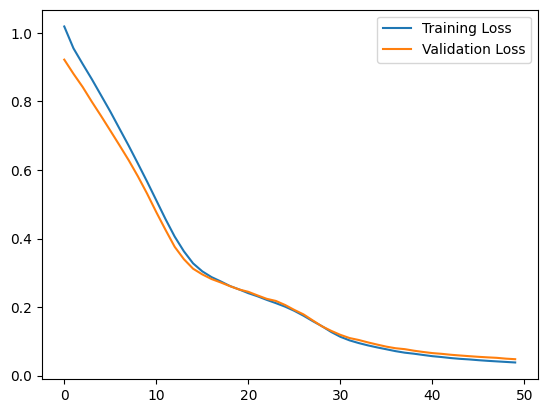

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


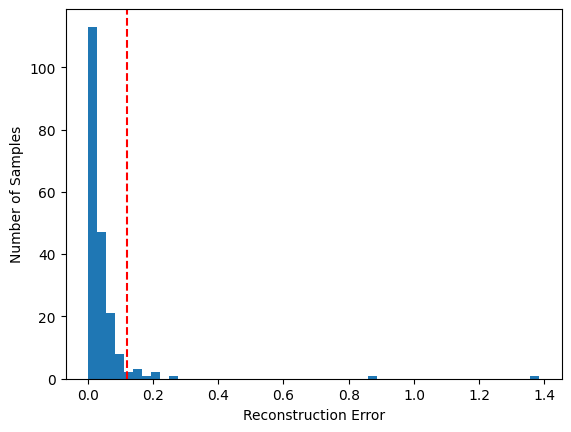

Number of anomalies detected: 10


In [44]:
import numpy as np

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict the reconstruction on the test data
X_test_pred = autoencoder.predict(X_test_ae)
mse = np.mean(np.square(X_test_ae - X_test_pred), axis=1)

# Calculate the reconstruction error threshold
threshold = np.percentile(mse, 95)

# Identify anomalies
anomalies = mse > threshold

# Plot the reconstruction error
plt.hist(mse, bins = 50)
plt.axvline(threshold, color = 'r', linestyle = '--')
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.show()

# Print number of anomalies detected
print(f'Number of anomalies detected: {np.sum(anomalies)}')

### Model Comparison: Isolation Forest vs Autoencoder

In [45]:
# Isolation Forest
if_scores = -iso_model.decision_function(X_test)

roc_if = roc_auc_score(y_test, if_scores)
precision_if, recall_if, _ = precision_recall_curve(y_test, if_scores)

# Autoencoder
X_test_pred = autoencoder.predict(X_test_ae)
mse = np.mean(np.square(X_test_ae - X_test_pred), axis=1)

roc_ae = roc_auc_score(y_test, mse)
precision_ae, recall_ae, _ = precision_recall_curve(y_test, mse)

print(f"Isolation Forest ROC-AUC: {roc_if}")
print(f"Autoencoder ROC-AUC: {roc_ae}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Isolation Forest ROC-AUC: 1.0
Autoencoder ROC-AUC: 0.9897959183673469
